# 신경망 모델 훈련

In [1]:
from torchvision.datasets import FashionMNIST

fm_train=FashionMNIST(root='.',train=True,download=True)
fm_test=FashionMNIST(root='.',train=True,download=True)

train_input=fm_train.data
train_target=fm_train.targets
train_scaled=train_input/255.0

from sklearn.model_selection import train_test_split

train_scaled,val_scaled,train_target,val_target=train_test_split(train_scaled,train_target,test_size=0.2,random_state=42)

In [2]:
import torch.nn as nn

model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100,10)
)

import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [3]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())

In [4]:
train_hist=[]
val_hist=[]
patience=2
best_loss=-1
early_stopping_counter=0

In [5]:
epochs=20
batches=int(len(train_scaled)/32)
for epoch in range(epochs):
    model.train()
    train_loss=0
    for i in range(batches):
        inputs=train_scaled[i*32:(i+1)*32].to(device)
        targets=train_target[i*32:(i+1)*32].to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    model.eval()
    val_loss=0
    with torch.no_grad():
        val_scaled=val_scaled.to(device)
        val_target=val_target.to(device)
        outputs=model(val_scaled)
        loss=criterion(outputs,val_target)
        val_loss=loss.item()

    train_hist.append(train_loss/batches)
    val_hist.append(val_loss)
    print(f"에포크:{epoch+1},",
          f"훈련 손실:{train_loss/batches:.4f},검증손실:{val_loss:.4f}")
    
    if best_loss==-1 or val_loss<best_loss:
        best_loss=val_loss
        early_stopping_counter=0
        torch.save(model.state_dict(),'best_model.pt')
    else:
        early_stopping_counter+=1
        if early_stopping_counter>=patience:
            print(f"{epoch+1}번째 에포크에서 조기 종료되었습니다.")
            break

에포크:1, 훈련 손실:0.6088,검증손실:0.4383
에포크:2, 훈련 손실:0.4448,검증손실:0.3942
에포크:3, 훈련 손실:0.4065,검증손실:0.3741
에포크:4, 훈련 손실:0.3877,검증손실:0.3604
에포크:5, 훈련 손실:0.3709,검증손실:0.3488
에포크:6, 훈련 손실:0.3567,검증손실:0.3438
에포크:7, 훈련 손실:0.3485,검증손실:0.3400
에포크:8, 훈련 손실:0.3402,검증손실:0.3372
에포크:9, 훈련 손실:0.3330,검증손실:0.3363
에포크:10, 훈련 손실:0.3252,검증손실:0.3351
에포크:11, 훈련 손실:0.3202,검증손실:0.3274
에포크:12, 훈련 손실:0.3147,검증손실:0.3285
에포크:13, 훈련 손실:0.3079,검증손실:0.3252
에포크:14, 훈련 손실:0.3048,검증손실:0.3300
에포크:15, 훈련 손실:0.3030,검증손실:0.3263
15번째 에포크에서 조기 종료되었습니다.


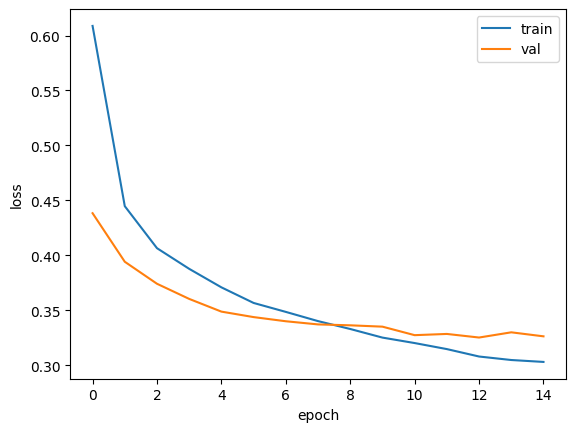

In [6]:
import matplotlib.pyplot as plt

plt.plot(train_hist,label='train')
plt.plot(val_hist,label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [7]:
model.load_state_dict(torch.load('best_model.pt',weights_only=True))

<All keys matched successfully>

In [8]:
model.eval()
with torch.no_grad():
    val_scaled=val_scaled.to(device)
    val_target=val_target.to(device)
    outputs=model(val_scaled)
    predicts=torch.argmax(outputs,1)
    corrects=(predicts==val_target).sum().item()

accuracy=corrects/len(val_target)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.8814
